In [1]:
projectDir = paths.concat('/home/local/yhasson/baselines/tzionas/pose-hg-train')
datasetName = 'uciego'

In [2]:
paths.dofile(projectDir .. '/src/ref.lua')

Saving everything to: /home/local/yhasson/baselines/tzionas/pose-hg-train/exp/uciego/default	


Found Environment variable CUDNN_PATH = /home/ROCQ/willow/yhasson/lib/libcudnn.so.5	


opt.dataDir : /home/local/yhasson/baselines/tzionas/pose-hg-train/data/uciego	


Input is a tensor with dimensions: 3 x 256 x 256	
Output is a table	
	 Entry 1 is a tensor with dimensions: 20 x 64 x 64	
	 Entry 2 is a tensor with dimensions: 20 x 64 x 64	
	 Entry 3 is a tensor with dimensions: 20 x 64 x 64	
	 Entry 4 is a tensor with dimensions: 20 x 64 x 64	
	 Entry 5 is a tensor with dimensions: 20 x 64 x 64	
	 Entry 6 is a tensor with dimensions: 20 x 64 x 64	
	 Entry 7 is a tensor with dimensions: 20 x 64 x 64	
	 Entry 8 is a tensor with dimensions: 20 x 64 x 64	
# of training images:	[torch.LongStorage of size 0]

# of validation images:	[torch.LongStorage of size 0]


In [3]:
idxs, preds, hms, inp = loadPreds('uciego/final-uci-ego-preds-80-epoch/final_preds', true, false)


Heatmaps: (red - ground truth, blue - predicted)	


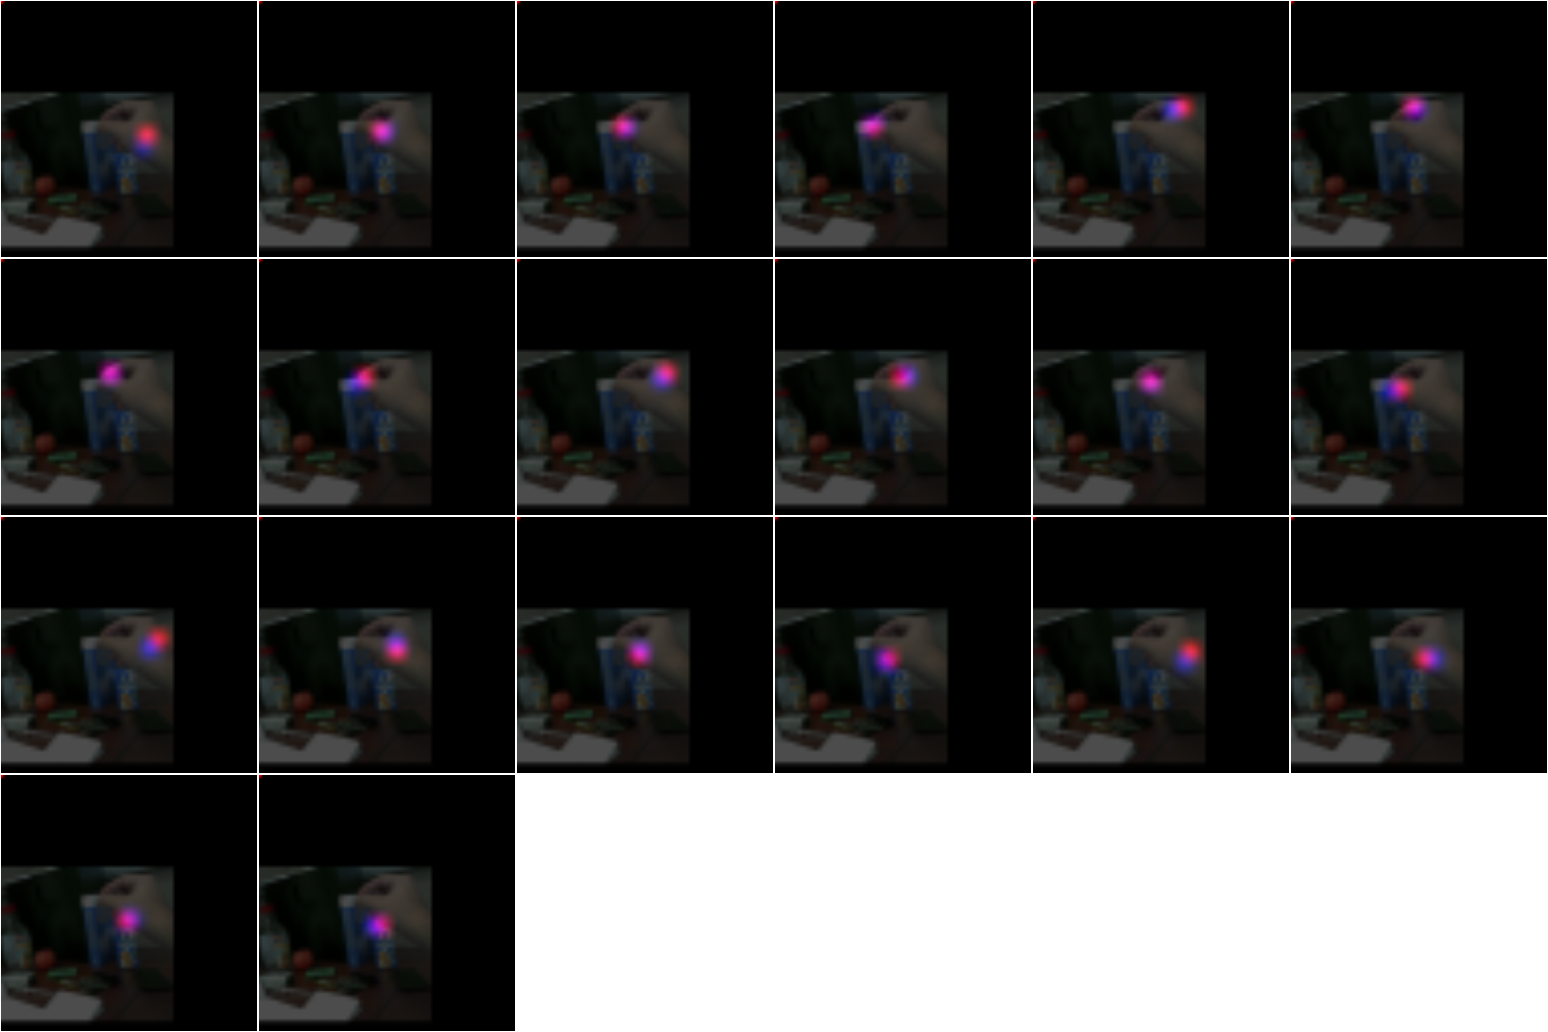

In [4]:
tmpIdx = 287
if hms then
    -- Prepare heatmap visualization
    local hmImg = heatmapVisualization('test',idxs[tmpIdx],hms[tmpIdx])
    print("Heatmaps: (red - ground truth, blue - predicted)"); sys.sleep(.01)
    itorch.image(hmImg)
end

In [5]:
tmpIdx = 287
imgIdx = idxs[tmpIdx]
-- preds = getPreds(nn.utils.addSingletonDimension(hms[tmpIdx]))
pred = preds[tmpIdx]:narrow(2,1,2):clone()
pred = getPreds(nn.utils.addSingletonDimension(hms[tmpIdx]))
gt = dataset:getPartInfo(imgIdx)
gt = nn.utils.addSingletonDimension(gt)
inp, gt_hms = loadData('test',{imgIdx})
gt_hm = gt_hms[1][1]
gt = getPreds(nn.utils.addSingletonDimension(gt_hm))

In [6]:

dists = calcDists(pred, gt, torch.ones(preds:size(1))*opt.outputRes/10)

In [7]:
displayPCK({dists}, {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}, {'sample'}, 'PCK', true)

PCK	


sample	0.94999998807907	


In [10]:
gts = loadData('test', idxs )
dists = calcDists(preds, gt, torch.ones(preds:size(1))*opt.outputRes/10)

inconsistent tensor size at /home/local/yhasson/git-installs/torch/pkg/torch/lib/TH/generic/THTensorMath.c:2950
stack traceback:
	[C]: at 0x7f738f178110
	[C]: in function 'dist'
	...hasson/baselines/tzionas/pose-hg-train/src/util/eval.lua:21: in function 'calcDists'
	[string "gts = loadData('test', idxs )..."]:2: in main chunk
	[C]: in function 'xpcall'
	...git-installs/torch/install/share/lua/5.1/itorch/main.lua:210: in function <...git-installs/torch/install/share/lua/5.1/itorch/main.lua:174>
	...git-installs/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	...-installs/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	...-installs/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	...-installs/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	...git-installs/torch/install/share/lua/5.1/itorch/main.lua:389: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00405d50: 